In [4]:
# PIP INSTALLS
pip install -U sentence-transformers cleanlab hdbscan umap umap-learn[plot] wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
# IMPORTS

from cleanlab.outlier import OutOfDistribution
from enum import Enum
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from PIL import Image
from seg_algorithm import get_optimal_splits, get_segmented_sentences
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from umap.umap_ import INT32_MAX
from wordcloud import WordCloud

import cleanlab
import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import sklearn.cluster as cluster
import string
import torch
import torch.nn.functional as F
import umap
import unicodedata

nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [130]:
# Constants
URL = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/presidential_speeches.csv"
stop_words = set(stopwords.words('english')) # switched to sklearn as it is larger than nltk stopwords
dataset = pd.read_csv(URL)
p = 0.65 #increase p = no of segments decreases


## REF: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# List of Presidents
class PresidentIndex(Enum):
  George_Washington = 0
  John_Adams = 1
  Thomas_Jefferson = 2
  James_Madison = 3
  James_Monroe = 4
  John_Quincy_Adams = 5
  Andrew_Jackson = 6
  Martin_Van_Buren = 7
  William_Harrison = 8
  John_Tyler = 9
  James_Polk = 10
  Zachary_Taylor = 11
  Millard_Fillmore = 12
  Franklin_Pierce = 13
  James_Buchanan = 14
  Abraham_Lincoln = 15
  Andrew_Johnson = 16
  Ulysses_Grant = 17
  Rutherford_Hayes = 18
  James_Garfield = 19
  Chester_Arthur = 20
  Grover_Cleveland_1 = 21
  Benjamin_Harrison = 22
  Grover_Cleveland_2 = 23
  William_McKinley = 24
  Theodore_Roosevelt = 25
  William_Taft = 26
  Woodrow_Wilson = 27
  Warren_Harding = 28
  Calvin_Coolidge = 29
  Herbert_Hoover = 30
  Franklin_Roosevelt = 31
  Harry_Truman = 32
  Dwight_Eisenhower = 33 
  John_Kennedy= 34
  Lyndon_Johnson = 35
  Richard_Nixon = 36
  Gerald_Ford = 37
  James_Carter = 38
  Ronald_Reagan = 39
  George_Bush_SR = 40
  William_Clinton = 41
  George_Bush = 42
  Barack_Obama = 43
  Donald_Trump = 44

# Set Presidents to use
PRESIDENTS = [PresidentIndex.George_Washington, PresidentIndex.Abraham_Lincoln];
PRESIDENT_NAMES = [n.name for n in PRESIDENTS]

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
additional_stopwords = []


# Get data samples and associated president
data_samples = []
data_classes = []

## TODO: VERIFY ALL PRES NAMES MATCH

for index, row in dataset.iterrows():
  underscoreName = row['President'].replace(' ', '_')
  
  if underscoreName in PRESIDENT_NAMES:
    data_samples.append(row['Transcript'])
    data_classes.append(PresidentIndex[underscoreName].value)


---
Before removing POS that are not nouns and lemmatization:
df_token_lists.shape: (36, 17955)
df_token_lists.head(5):
       0         1            2           3                4     5             6         7             8            9         10               11              12         13            14           15      16       17        18          19         20         21       22         23            24          25           26        27        28           29            30      31         32             33        34              35            36      37           38          39        40          41         42           43         44          45            46          47       48            49         50             51          52         53           54        55        56            57              58        59             60        61       62          63         64             65          66          67         68            69            70        71        72           7

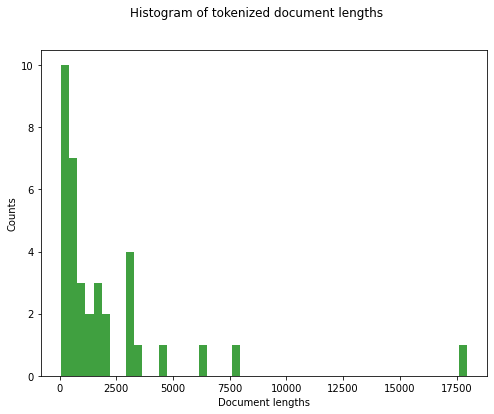

In [132]:
# Pre-Processing Helpers
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')


# Pre-Processing
def preprocess_documents(data_samples, president_names, general_stopwords, additional_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=False, is_plot=False):
  '''
  Preprocess documents
  
  Parameters:
  data_samples: list of data samples
  president_names: list of president names
  general_stopwords: list of stopwords used in general
  additional: domain specific stopwords that should not appear in the word cloud
  stemmer: the stemmer method
  lemmatizer: the lemmatizer method
  is_skip_header: boolean to skip the header section in each newsgroup
  
  Return:
  df_token_lists: dataframe of tokenized word lists
  df_lem_strings: dataframe of lemmatized word lists
  data_samples_processed: list of the processed lemmatized strings
  data_processed: list of tuples of data_samples_processed and their data classes
  '''

  # POS (Parts Of Speech)
  # For: nouns, adjectives, verbs and adverbs use {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
  DI_POS_TYPES = {'NN':'n'}  # Just the nouns
  POS_TYPES = list(DI_POS_TYPES.keys())

  # Constraints on tokens
  MIN_STR_LEN = 4
  MAX_TOKENS = INT32_MAX
  RE_VALID = '[a-zA-Z]'
  PUNCT = ['@', '_', '.']

  # Process all data samples
  li_tokens = []
  li_token_lists = []
  li_lem_strings = []
  len_tokens = []
  
  for i,text in enumerate(data_samples):

      # Tokenize by sentence, then by lowercase word
      tokens = []
      if is_skip_header:
        # Skip most of the first section that represents the header metadata
        for j,sent in enumerate(nltk.sent_tokenize(text)):
          if j == 0:
            li_sents = [s.strip() for s in sent.splitlines()]
            li_sents = [s for s in li_sents if len(s) > 0 and not s.lower().startswith(tuple(domain_stopwords))]
            tokens0 = [token.lower() for sent in li_sents for token in nltk.word_tokenize(sent)]
            tokens = []
            for t in tokens0:
              is_in = False
              for p in PUNCT:
                if p in t:
                  is_in = True
                  break
                  
              if not is_in:    
                tokens.append(t)
              
            continue

          for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
      else:
        tokens = [token.lower() for sent in nltk.sent_tokenize(text) for token in nltk.word_tokenize(sent)]
      
      # Remove stopwords
      tokens = [x for x in tokens if x not in general_stopwords]
      tokens = [x for x in tokens if x not in domain_stopwords] 
      
      # Limit
      tokens = tokens[:MAX_TOKENS]
      len_tokens.append(len(tokens))

      # Process all tokens per quote
      li_tokens_quote = []
      li_tokens_quote_lem = []
      for token in tokens:
          # Remove email addresses
          if '@' in token:
            continue
          
          # Remove accents
          t = remove_accents(token)

          # Remove misc
          t = remove_misc(t)

          # Remove punctuation
          t = str(t).translate(string.punctuation)
          li_tokens_quote.append(t)

          # Add token that represents "no lemmatization match"
          li_tokens_quote_lem.append('-') # this token will be removed if a lemmatization match is found below

          # Process each token
          if t not in general_stopwords:
              if re.search(RE_VALID, t):
                  if len(t) >= MIN_STR_LEN:
                      # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                      # (otherwise it assumes the word is a noun)
                      pos = nltk.pos_tag([t])[0][1][:2]
                      pos2 = 'n'  # set default to noun
                      if pos in DI_POS_TYPES:
                        pos2 = DI_POS_TYPES[pos]

                      stem = stemmer.stem(t)
                      lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                      if pos in POS_TYPES:
                          li_tokens.append((t, stem, lem, pos))

                          # Remove the '-' token and append the lemmatization match
                          li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                          li_tokens_quote_lem.append(lem)

      # Build list of token lists from lemmatized tokens
      li_token_lists.append(li_tokens_quote)

      # Build list of strings from lemmatized tokens
      str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
      li_lem_strings.append(str_li_tokens_quote_lem)

  # Build resulting dataframes from lists
  df_token_lists = pd.DataFrame(li_token_lists)

  # Replace None with empty string
  for c in df_token_lists:
      if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
          df_token_lists[c].fillna(value='', inplace=True)

  df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem string'])

  # Build a dataset that corresponds the processed strings to the class labels
  data_samples_processed = [x.replace('-','') for x in li_lem_strings]
  data_processed = list(zip(president_names, data_samples_processed))
  
  if is_print:
    print("---")
    print("Before removing POS that are not nouns and lemmatization:")
    print("df_token_lists.shape:", df_token_lists.shape)
    print("df_token_lists.head(5):")
    print(df_token_lists.head(5).to_string())
    
    print("---")
    print("After removing POS that are not nouns and lemmatization:")
    print("df_lem_strings.head():")
    print(df_lem_strings.head().to_string())
    
    print("---")
    for i,v in enumerate(data_processed[:5]):
      print(i,v)

  # Plot histogram of tokenized document lengths
  if is_plot:
    fig = plt.figure(figsize=(8,6))
    plt.suptitle("Histogram of tokenized document lengths")
    plt.xlabel("Document lengths")
    plt.ylabel("Counts")
    n, bins, patches = plt.hist(len_tokens, bins=50, density=False, facecolor='g', alpha=0.75)
    plt.show()
  
  return df_token_lists, df_lem_strings, data_samples_processed, data_processed

# Preprocess documents
df_token_lists, df_lem_strings, data_samples_processed, data_processed = \
  preprocess_documents(data_samples, data_classes, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=True, is_plot=True)

In [83]:
# Segmentation
segmentation  = get_optimal_splits(embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(filteredTranscript, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [27]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [28]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform(embeddings)
print(reduced_embedding.shape)

(754, 220)


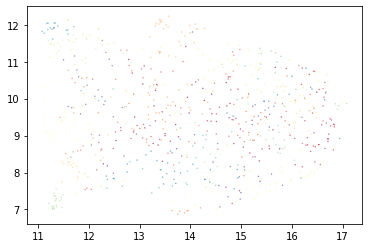

In [29]:
kmeans_labels = cluster.KMeans(n_clusters=30).fit_predict(reduced_embedding)
standard_embedding = umap.UMAP(random_state=42).fit_transform(reduced_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

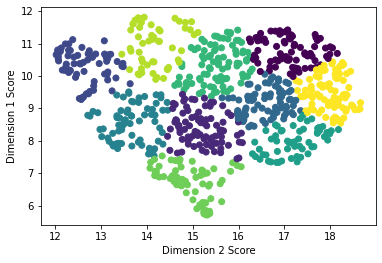

In [30]:
#Umap Clustering

reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(embeddings)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=10)
kmeans.fit(sentences_embeddings_reduced)

# Get the cluster labels for each sentence
labels = kmeans.labels_
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels)
plt.xlabel('Dimension 2 Score')
plt.ylabel('Dimension 1 Score')
plt.show()


In [47]:
# Build tf-idf vectorizer and related variables from the input documents
# to support both unigrams and bigrams use: ngram_range=(1,2)
def build_vectorizer(documents, ngram_range=(1,1), max_df=1.0, min_df=1, stop_words=None, max_features=None):   # default CountVectorizer parameter values
    '''
    (i) Build count_vectorizer from the documents and fit the documents  
    (ii) Build TF (Term Frequency) from the documents, this is a sparse version of the bag-of-words  
    (iii) Build bag-of-words in two steps: fit, transform  
    (iv) Get feature names and build dataframe version of the bag-of-words  
    (v) Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)  
    (vi) Find most popular words and highest weights  
    (vii) Build word weights as a list and sort them  
    (viii) Calculate cosine similarity of all documents with themselves  
    (ix) Calculate distance matrix of documents  
    
    Note:
    The TF_IDF matrix can be built directly with 'TfidfVectorizer' instead of using 'CountVectorizer' followed by 'TfidfTransformer'
    
    Return:
    cvec: CountVectorizer
    tf: Term Frequencies
    tfidf: TF-IDF matrix 
    feature_names: Feature names in TF-IDF
    df_bag_of_words: Bag of words from the sparse Term Frequencies
    df_weights: Most popular words, word counts and highest weights
    cos_sim: Cosine similarity of all documents with themselves
    samp_dist: Distance matrix of documents
    '''
    
    # Build CountVectorizer from the documents and fit the documents
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df, stop_words=stop_words, max_features=max_features)
    
    # Build TF (Term Frequencies) from the documents, this is a sparse version of the bag-of-words
    tf = count_vectorizer.fit_transform(documents)  # note that the LDA transform needs this for its clustering model (explained below)

    # Build bag-of-words in two steps: fit, transform
    cvec = count_vectorizer.fit(documents)
    bag_of_words = cvec.transform(documents)
    
    # Get feature names and build dataframe version of the bag-of-words
    feature_names = cvec.get_feature_names_out()
    df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)
    
    # Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bag_of_words)

    # Find most popular words, word counts and highest weights
    word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
    df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
    df_cnts = df_cnts.sort_values('count', ascending=False)

    # Build word weights as a list and sort them (the dataframe below also contains the counts)
    weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
    df_weights = df_weights.sort_values('weight', ascending=False)

    df_weights = df_weights.merge(df_cnts, on='word', how='left')
    df_weights = df_weights[['word', 'count', 'weight']]

    # Calc cosine similarity of all documents with themselves
    cos_sim = metrics.pairwise.cosine_similarity(tfidf, tfidf)

    # Calc distance matrix of documents
    samp_dist = 1 - cos_sim

    return cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist

In [56]:
def word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True):
  # print("Category:", TARGET_NAMES[i_class])
  print("----------------------------------")
  data_samples_group = [x for i,x in enumerate(data_samples)]
  data_classes_group = [i_class] * len(data_samples_group)
  
  # Preprocess documents
  df_token_lists_per_class, df_lem_strings_per_class, data_samples_processed_per_class, data_processed_per_class = \
    preprocess_documents(data_samples_group, data_classes_group, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header)
  
  # Build TF-IDF matrices
  li_lem_strings = df_lem_strings_per_class['lem string'].values.tolist()
  cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = \
    build_vectorizer(li_lem_strings)

  # Build word cloud
  cloud = word_cloud(df_weights)
  return cloud

In [39]:
def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

In [61]:
def preprocess_documents(data_samples, data_classes, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=False, is_plot=False):
  '''
  Preprocess documents
  
  Parameters:
  data_samples: list of data samples
  data_classes: list of classes
  general_stopwords: list of stopwords used in general
  domain_stopwords: domain specific stopwords that should not appear in the word cloud
  stemmer: the stemmer method
  lemmatizer: the lemmatizer method
  is_skip_header: boolean to skip the header section in each newsgroup
  
  Return:
  df_token_lists: dataframe of tokenized word lists
  df_lem_strings: dataframe of lemmatized word lists
  data_samples_processed: list of the processed lemmatized strings
  data_processed: list of tuples of data_samples_processed and their data classes
  '''

  # POS (Parts Of Speech)
  # For: nouns, adjectives, verbs and adverbs use {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
  DI_POS_TYPES = {'NN':'n'}  # Just the nouns
  POS_TYPES = list(DI_POS_TYPES.keys())

  # Constraints on tokens
  MIN_STR_LEN = 3
  MAX_TOKENS = 1200
  RE_VALID = '[a-zA-Z]'
  PUNCT = ['@', '_', '.']

  # Process all data samples
  li_tokens = []
  li_token_lists = []
  li_lem_strings = []
  len_tokens = []
  
  for i,text in enumerate(data_samples):

      # Tokenize by sentence, then by lowercase word
      tokens = []
      if is_skip_header:
        # Skip most of the first section that represents the header metadata
        for j,sent in enumerate(nltk.sent_tokenize(text)):
          if j == 0:
            li_sents = [s.strip() for s in sent.splitlines()]
            li_sents = [s for s in li_sents if len(s) > 0 and not s.lower().startswith(tuple(domain_stopwords))]
            tokens0 = [token.lower() for sent in li_sents for token in nltk.word_tokenize(sent)]
            tokens = []
            for t in tokens0:
              is_in = False
              for p in PUNCT:
                if p in t:
                  is_in = True
                  break
                  
              if not is_in:    
                tokens.append(t)
              
            continue

          for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
      else:
        tokens = [token.lower() for sent in nltk.sent_tokenize(text) for token in nltk.word_tokenize(sent)]
      
      # Remove stopwords
      tokens = [x for x in tokens if x not in general_stopwords]
      tokens = [x for x in tokens if x not in domain_stopwords] 
      
      # Limit
      tokens = tokens[:MAX_TOKENS]
      len_tokens.append(len(tokens))

      # Process all tokens per quote
      li_tokens_quote = []
      li_tokens_quote_lem = []
      for token in tokens:
          # Remove email addresses
          if '@' in token:
            continue
          
          # Remove accents
          # t = remove_accents(token)

          # Remove misc
          # t = remove_misc(t)

          # Remove punctuation
          t = str(t).translate(string.punctuation)
          li_tokens_quote.append(t)

          # Add token that represents "no lemmatization match"
          li_tokens_quote_lem.append('-') # this token will be removed if a lemmatization match is found below

          # Process each token
          if t not in general_stopwords:
              if re.search(RE_VALID, t):
                  if len(t) >= MIN_STR_LEN:
                      # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                      # (otherwise it assumes the word is a noun)
                      pos = nltk.pos_tag([t])[0][1][:2]
                      pos2 = 'n'  # set default to noun
                      if pos in DI_POS_TYPES:
                        pos2 = DI_POS_TYPES[pos]

                      stem = stemmer.stem(t)
                      lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                      if pos in POS_TYPES:
                          li_tokens.append((t, stem, lem, pos))

                          # Remove the '-' token and append the lemmatization match
                          li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                          li_tokens_quote_lem.append(lem)

      # Build list of token lists from lemmatized tokens
      li_token_lists.append(li_tokens_quote)

      # Build list of strings from lemmatized tokens
      str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
      li_lem_strings.append(str_li_tokens_quote_lem)

  # Build resulting dataframes from lists
  df_token_lists = pd.DataFrame(li_token_lists)

  # Replace None with empty string
  for c in df_token_lists:
      if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
          df_token_lists[c].fillna(value='', inplace=True)

  df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem string'])

  # Build a dataset that corresponds the processed strings to the class labels
  data_samples_processed = [x.replace('-','') for x in li_lem_strings]
  data_processed = list(zip(data_classes, data_samples_processed))
  
  if is_print:
    print("---")
    print("Before removing POS that are not nouns and lemmatization:")
    print("df_token_lists.shape:", df_token_lists.shape)
    print("df_token_lists.head(5):")
    print(df_token_lists.head(5).to_string())
    
    print("---")
    print("After removing POS that are not nouns and lemmatization:")
    print("df_lem_strings.head():")
    print(df_lem_strings.head().to_string())
    
    print("---")
    for i,v in enumerate(data_processed[:5]):
      print(i,v)

  # Plot histogram of tokenized document lengths
  if is_plot:
    fig = plt.figure(figsize=(8,6))
    plt.suptitle("Histogram of tokenized document lengths")
    plt.xlabel("Document lengths")
    plt.ylabel("Counts")
    n, bins, patches = plt.hist(len_tokens, bins=50, density=False, facecolor='g', alpha=0.75)
    plt.show()
  
  return df_token_lists, df_lem_strings, data_samples_processed, data_processed

In [48]:
li_lem_strings = filteredTranscript
cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = build_vectorizer(li_lem_strings)

In [64]:
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
domain_stopwords = ['subject', 'organization', 'lines', 'from', 'reply-to', 'distribution', 'keywords', 'article', 'newsreader', 'nntp-posting-host', 'writes', 'x-newsreader', 'summary']

i_class = 0
word_cloud_per_class(i_class, filteredTranscript, stop_words, stop_words, stemmer, lemmatizer, is_skip_header=True)

----------------------------------


ValueError: ignored

['16th', '17th', 'abusing', 'accepting', 'acquiesce', 'admittance', 'affect', 'amounting', 'appearing', 'assaulting', 'avowing', 'circuitous', 'circulating', 'comply', 'cruel', 'david', 'defeat', 'detaining', 'disappointed', 'disguised', 'enacted', 'existed', 'fly', 'gaining', 'hardy', 'highways', 'humiliating', 'hundreds', 'injuring', 'insomuch', 'intention', 'intercepting', 'languish', 'lenox', 'levying', 'lowering', 'marshals', 'menaces', 'mystrenuous', 'neville', 'night', 'oblige', 'ofcandor', 'overt', 'proceeded', 'punishments', 'rounded', 'route', 'subversive', 'suggestion']


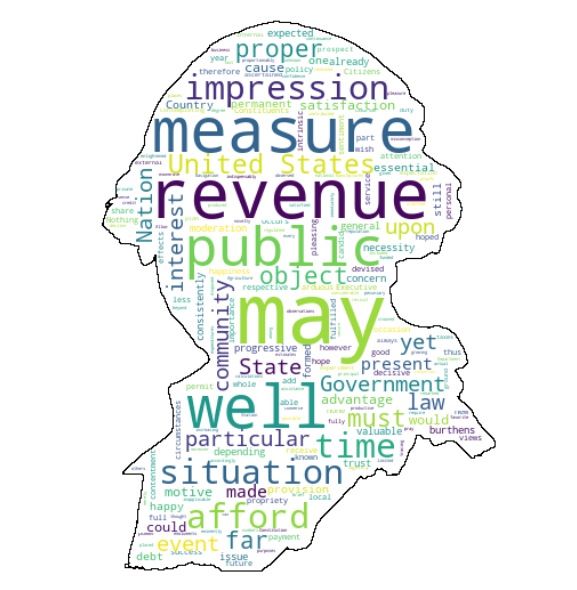

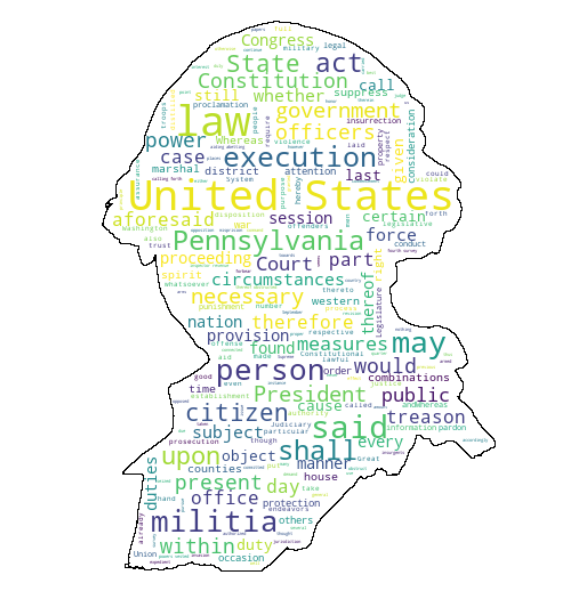

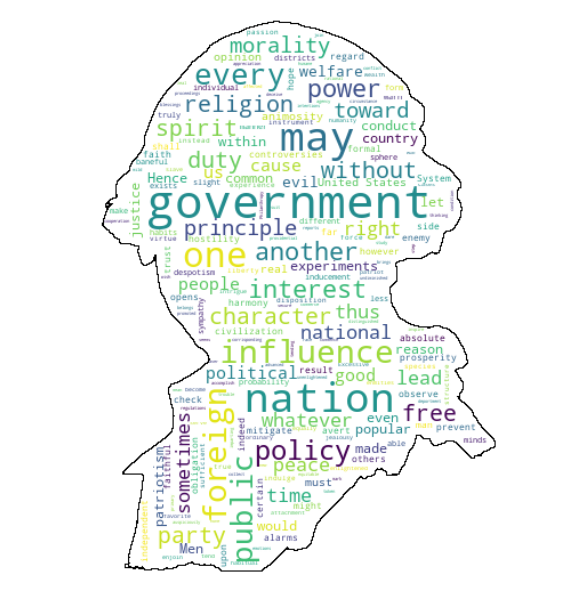

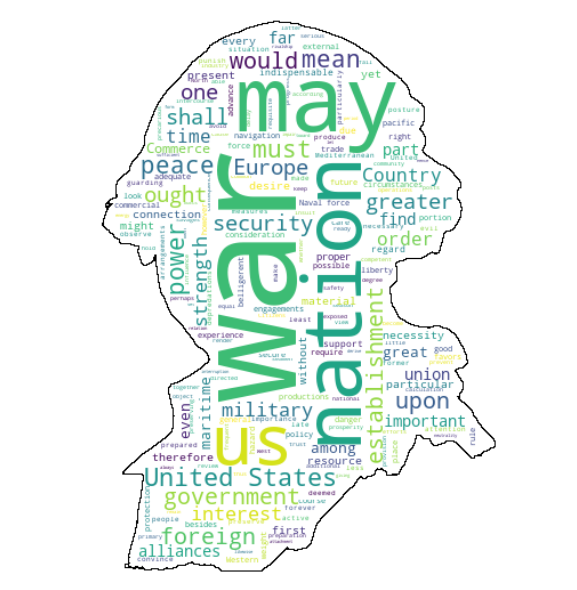

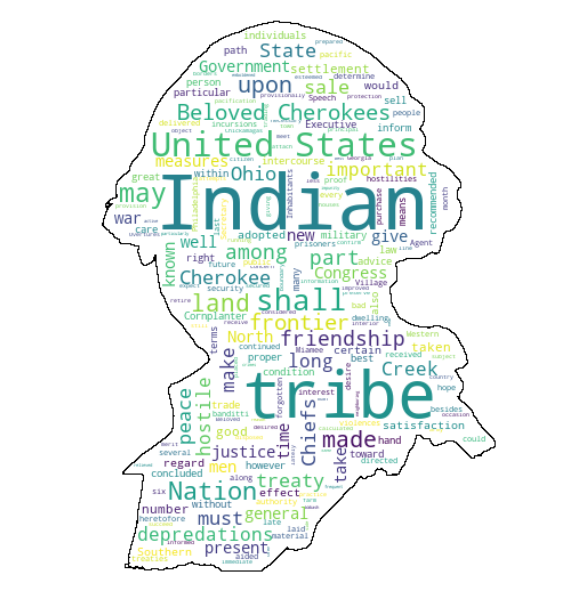

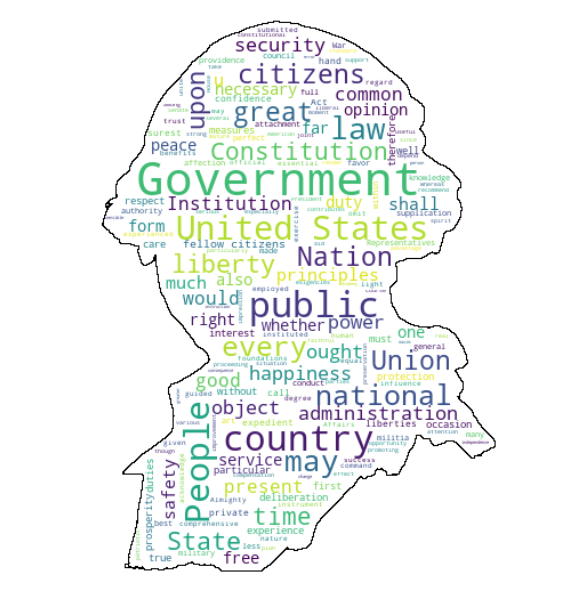

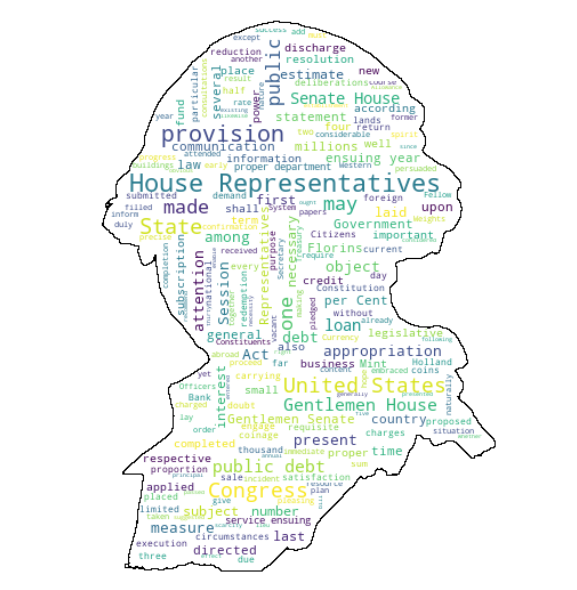

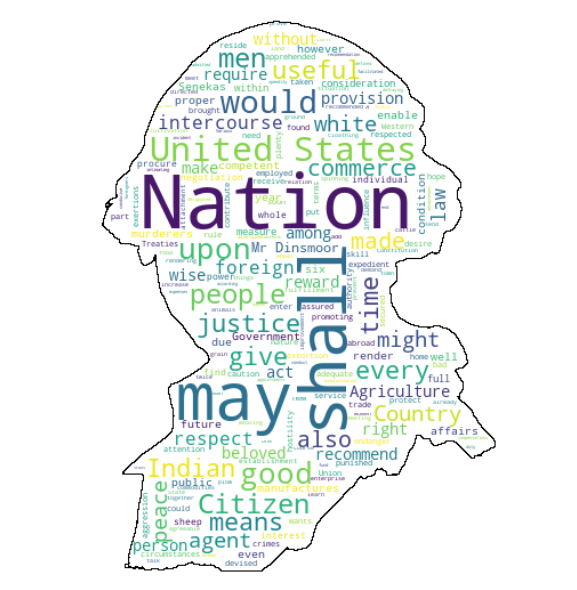

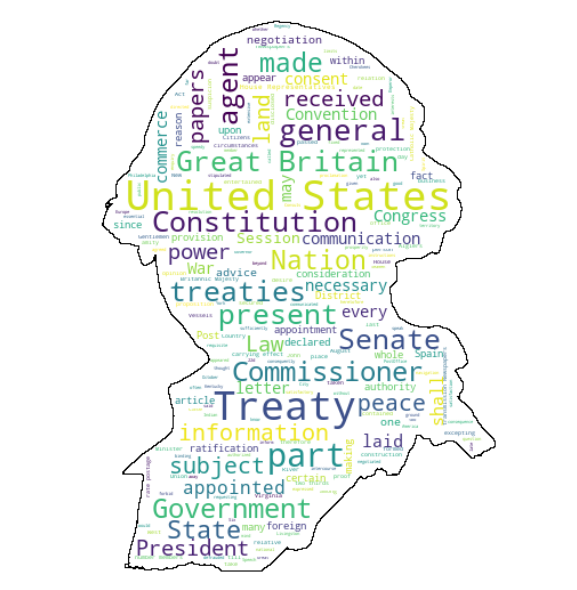

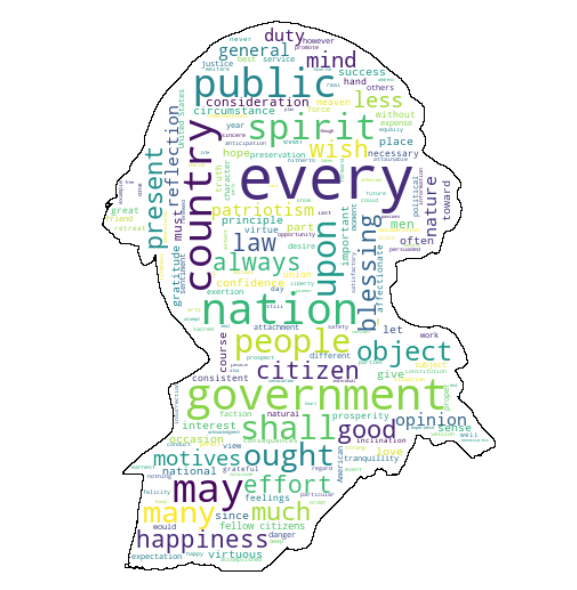

In [ ]:
#Original method - probably using this


# Your list of tokenized sentences

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(filteredTranscript)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

# Print the 50 words with the lowest tf-idf scores
# print("50 words with the lowest tf-idf scores:")
# print(sorted_words[:50])
lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

#print(len(filteredTranscript))
#low_tfidf = lowest_tfidf_words(filteredTranscript)
#print(len(lowest_tfidf_words(filteredTranscript)))
mask = np.array(Image.open('gw.png'))

for i in range(kmeans.n_clusters):
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [filteredTranscript[index] for index in cluster_indices]

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words])
    # Generate a word cloud from the cluster text


    wordcloud = WordCloud(min_font_size=4, 
                          mask=mask,
                          width=mask.shape[1],
                          height=mask.shape[0],
                          stopwords=lowest_tfidf_words, 
                          background_color="white",
                          contour_width=1,
                          contour_color="black")
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

In [ ]:
# PrePCA Cosine Similarity Matrix
heatmap = np.zeros(shape=(len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    sent = embeddings[i]
    for j in range(len(embeddings)):
        sent2 = embeddings[j]
        cosSim = cos_similarity(sent, sent2)
        heatmap[i,j] = cosSim

In [ ]:
# PostPCA Cosine Similarity Matrix (Sentence Similarity Matrix)
heatmapPost = np.zeros(shape=(len(reduced_embedding), len(reduced_embedding)))
for i in range(len(reduced_embedding)):
    sentPost = reduced_embedding[i]
    for j in range(len(reduced_embedding)):
        sent2Post = reduced_embedding[j]
        cosSimPost = cos_similarity(sentPost, sent2Post)
        heatmapPost[i,j] = cosSimPost

[[1.    0.382 0.445 ... 0.284 0.194 0.26 ]
 [0.382 1.    0.519 ... 0.33  0.208 0.306]
 [0.445 0.519 1.    ... 0.406 0.348 0.261]
 ...
 [0.284 0.33  0.406 ... 1.    0.234 0.334]
 [0.194 0.208 0.348 ... 0.234 1.    0.207]
 [0.26  0.306 0.261 ... 0.334 0.207 1.   ]]
done with PrePCA heatmap


In [ ]:
# Prenormalized Heatmaps

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCA[i,j] = heatmap[i,j]
data = heatmapPrePCA
plt.imshow( data , cmap = 'inferno' , vmax = .7, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCA[i,j] = heatmapPost[i,j]
data = heatmapPostPCA
plt.imshow( data , cmap = 'inferno' , vmax = .35, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Standardize the Data


heatmapStandard = StandardScaler().fit_transform(heatmap)
heatmapPostStandard = StandardScaler().fit_transform(heatmapPost)

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCAStandard[i,j] = heatmapStandard[i,j]
data = heatmapPrePCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCAStandard[i,j] = heatmapPostStandard[i,j]
data = heatmapPostPCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Normalized Heatmaps

# Normalize Pre and Post Cosine Similarity Matrixs
heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)
# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCANorm[i,j] = heatmapPreNorm[i,j]
data = heatmapPrePCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.6, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCANorm[i,j] = heatmapPostNorm[i,j]
data = heatmapPostPCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.5, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
plt.show()

In [ ]:
# Test Code

fullTranscripts = pd.DataFrame(fullTranscripts)
fullTranscripts.to_csv('fullTranscripts.csv')

embedding = pd.DataFrame(embedding)
embedding.to_csv('embedding.csv')

reduced_embedding = pd.DataFrame(reduced_embedding)
reduced_embedding.to_csv('reduced_embedding.csv')